# <center> HTF horizons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_excel("data.csv")
df = df.iloc[::-1]
df = df.reset_index()

## GARCH (1,1)

In [16]:
df['log_price'] = np.log(df['BTC']) 

In [17]:
df['pct_change'] = df['log_price'].diff() 

In [18]:
df['stdev'] = df['pct_change'].rolling(window=30, center=False).std()
df['Volatility'] = df['stdev'] * (252**0.5) 

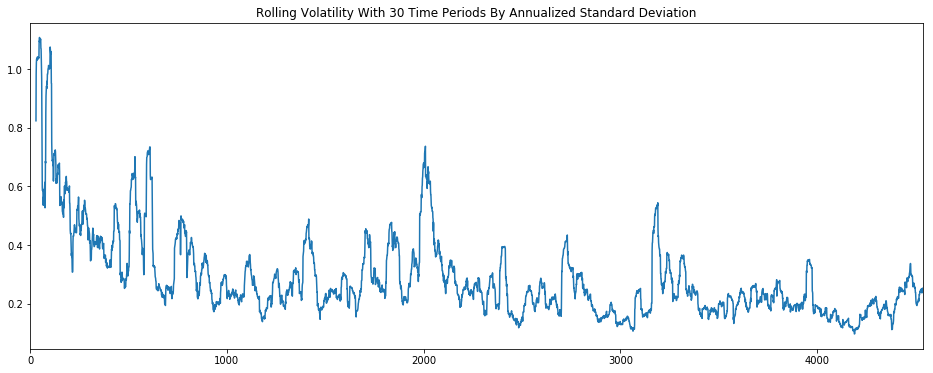

In [19]:
plt.figure(figsize=(16,6))
df['Volatility'].plot()
plt.title("Rolling Volatility With 30 Time Periods By Annualized Standard Deviation")
plt.show()

In [20]:
df = df.dropna()

In [21]:
vol = df["Volatility"] * 100

__The GARCH(1,1) model is:__

$$\sigma^2(t) = \alpha \cdot \sigma^2(t-1) + \beta \cdot e^2(t-1) + w$$

In [22]:
from arch import arch_model
am = arch_model(vol, vol='Garch', p=1, o=0, q=1, dist='Normal')

In [23]:
res = am.fit(disp='off')
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Volatility   R-squared:                      -0.136
Mean Model:             Constant Mean   Adj. R-squared:                 -0.136
Vol Model:                      GARCH   Log-Likelihood:               -14312.3
Distribution:                  Normal   AIC:                           28632.7
Method:            Maximum Likelihood   BIC:                           28658.3
                                        No. Observations:                 4508
Date:                Mon, Dec 17 2018   Df Residuals:                     4504
Time:                        15:32:24   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            23.2496      0.317     73.330      0.000 [ 22.628, 23.871]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.7656      0.129      5.935  2.945e-09   [  0.513,  1.018]
alpha[1]       0.8694  5.886e-02     14.771  2.251e-49   [  0.754,  0.985]
beta[1]        0.1254  6.045e-02      2.074  3.804e-02 [6.922e-03,  0.244]
==========================================================================

Covariance estimator: robust
"""

In [24]:
df['forecast_vol'] = 0.1 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + 
                                   res.conditional_volatility**2 * res.params['beta[1]'])

После обучения модели GARCH (1,1) по приведенной выше формуле можно прогнозировать реализованую волатильность.

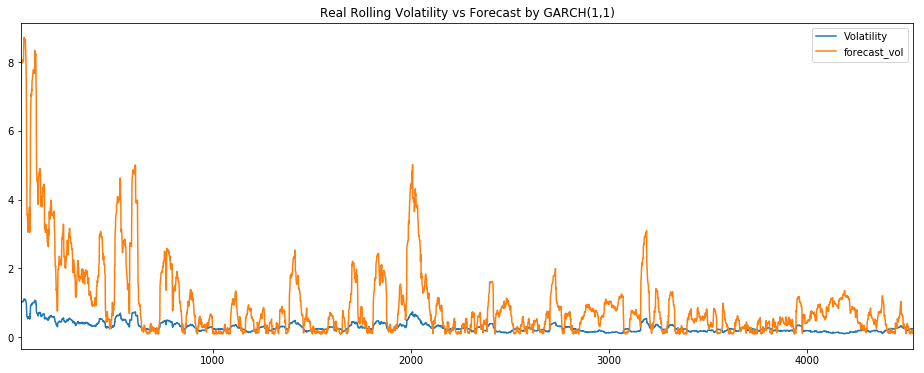

In [20]:
plt.figure(figsize=(16,6))
df["Volatility"].plot()
df["forecast_vol"].plot()
plt.title("Real Rolling Volatility vs Forecast by GARCH(1,1)")
plt.legend()
plt.show()

Для сравнения моделей между собой используем метрику  `rmse`.
$$\sum{\sqrt{(\hat{X_i}-X_i)^2}}$$

In [26]:
def rmse_tr(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
skor = rmse_tr(df.loc[df.index[1000:], 'forecast_vol'], df.loc[df.index[1000:], 'Volatility'])
print("Root Mean Squared Error of the model is calculated as ",skor)

Root Mean Squared Error of the model is calculated as  0.730762076704


## LSTM

 Модель с использованием `RNN`.  Генеируем последовательности, собираем необходимый датасет.

In [23]:
training_set = df.iloc[:, 11:12].values
X_train = []
y_train = []
for i in range(1000, df.shape[0]):
    X_train.append(training_set[i-1000:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [24]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [65]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
3508/3508 [==============================] - 238s 68ms/step - loss: 0.0100
Epoch 2/100
3508/3508 [==============================] - 207s 59ms/step - loss: 0.0030
Epoch 3/100
3508/3508 [==============================] - 207s 59ms/step - loss: 0.0024
Epoch 4/100
3508/3508 [==============================] - 208s 59ms/step - loss: 0.0020
Epoch 5/100
3508/3508 [==============================] - 210s 60ms/step - loss: 0.0019
Epoch 6/100
3508/3508 [==============================] - 207s 59ms/step - loss: 0.0016
Epoch 7/100
3508/3508 [==============================] - 207s 59ms/step - loss: 0.0017
Epoch 8/100
3508/3508 [==============================] - 207s 59ms/step - loss: 0.0015
Epoch 9/100
3508/3508 [==============================] - 208s 59ms/step - loss: 0.0014
Epoch 10/100
3508/3508 [==============================] - 209s 60ms/step - loss: 0.0012
Epoch 11/100
3508/3508 [==============================] - 208s 59ms/step - loss: 0.0012
Epoch 12/100
3508/3508 [=================

In [66]:
regressor.save('my_modelp1.h5')

In [27]:
from keras.models import load_model
regressor = load_model('my_modelp1.h5')

In [28]:
predicted_stock_price = regressor.predict(X_train)

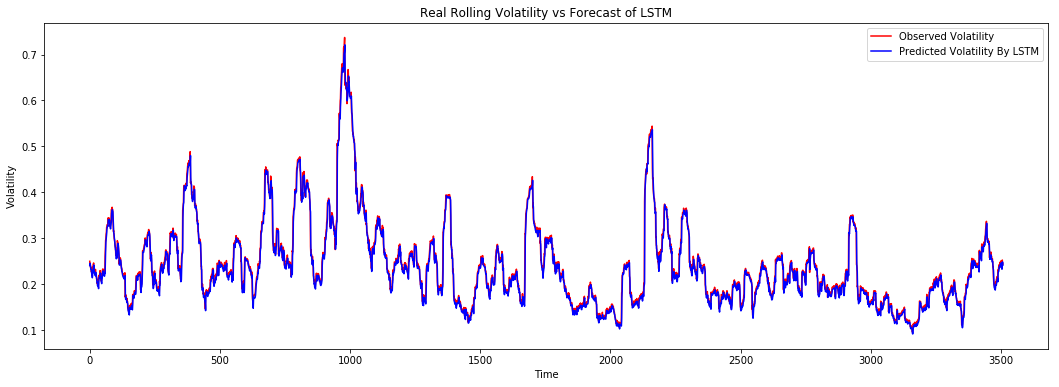

In [44]:
# Visualising the results
plt.figure(figsize=(18,6))
plt.plot(df.iloc[1000:, 11:12].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM')
plt.title('Real Rolling Volatility vs Forecast of LSTM')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [42]:
skor2 = rmse_tr(predicted_stock_price, np.array(df.loc[df.index[1000:], 'Volatility']))
print("Root Mean Squared Error of the model is calculated as ",skor2)

Root Mean Squared Error of the model is calculated as  0.131192360735


Резуьтаты LSTM модели получаеются заметно лучше для рассмтриваемого горизонта. Темне менее, предсказывать волтильность на небольшие горизонты не очень сложно. Интересно рассмотреть длинный горизонт. Для этого необходимо:

 - больше данных (несколько месяцев)
 - несколько другой подход к моделям